# Enhance your brand using YouTube


## 📖 Background
You're a data scientist at a global marketing agency that helps some of the world's largest companies enhance their online presence.

Your new project is exciting: identify the most effective YouTube videos to promote your clients’ brands.

Forget simple metrics like views or likes; your job is to dive deep and discover who really connects with audiences through innovative content analysis.

## 💾 The Data

The data for this competition is stored in two tables, `videos_stats` and `comments`.

### `videos_stats.csv`
This table contains aggregated data for each YouTube video:
- **Video ID**: A unique identifier for each video.
- **Title**: The title of the video.
- **Published At**: The publication date of the video.
- **Keyword**: The main keyword or topic of the video.
- **Likes**: The number of likes the video has received.
- **Comments**: The number of comments on the video.
- **Views**: The total number of times the video has been viewed.

### `comments.csv`
This table captures details about comments made on YouTube videos:
- **Video ID**: The identifier for the video the comment was made on (matches the `Videos Stats` table).
- **Comment**: The text of the comment.
- **Likes**: How many likes this comment has received.
- **Sentiment**: The sentiment score ranges from 0 (negative) to 2 (positive), indicating the tone of a comment.

# Executive Summary

This report explores how data science techniques can be used to identify the most effective YouTube videos for promoting a client's brand. It analyzes two datasets, "videos_stats.csv" containing video metadata and "comments.csv" containing comments on those videos.

Data Cleaning and Exploration
- Both datasets were cleaned to handle missing values, outliers, and data types.
- Exploratory data analysis revealed insights into video statistics, engagement metrics, and keyword classifications.

Engagement Metrics
- A new metric, "Engagement Rate," was calculated by combining likes, comments, and views.
- The average engagement rate was compared by keyword and industry to identify high-performing areas.

Keyword-Based Analysis
- Keywords were categorized into industries to understand industry-specific trends.
- Word clouds were used to visualize the most frequent keywords within each industry.

Sentiment Analysis
- Sentiment analysis was performed on comments to categorize them as positive, neutral, or negative.
- Overall sentiment was positive, with further exploration revealing industry-specific sentiment variations.
- Emotion analysis was conducted to identify the prevalence of various emotions in the comments.
- Average emotion scores were calculated by keyword and industry, revealing interesting trends.
- Time-series analysis showed the evolution of average emotion scores over time, uncovering potential peaks and trends.

Key Findings
- Engagement rate varies by keyword and industry.
- Positive comments are most common overall, but sentiment varies by industry.
- Trust is the dominant emotion, followed by anticipation and joy.
- Specific emotions show peaks and trends over time, offering insights into audience reactions.

# Preparing Data

## Install Libraries

In [231]:
!pip3 install nrclex seaborn wordcloud langdetect numpy pandas matplotlib tqdm scikit-learn nltk spacy plotly
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 29.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Importing Libraries

In [232]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nrclex import NRCLex
import nltk
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.figure_factory as ff
import warnings

nltk.download('punkt')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /Users/mac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Importing Data

In [262]:
videos_stats = pd.read_csv('videos_stats.csv')
comments = pd.read_csv('comments.csv')

## Cleaning Data

### Cleaning Video Data

In [258]:
vs_clean = videos_stats.copy()
for column in videos_stats.columns:
    if vs_clean[column].dtype == 'object':
        vs_clean[column].fillna(vs_clean[column].mode()[0], inplace=True)
    else:
        vs_clean[column].fillna(vs_clean[column].median(), inplace=True)
vs_clean['Published At'] = pd.to_datetime(vs_clean['Published At'], errors='coerce')
vs_clean.drop_duplicates(inplace=True)
q_low = vs_clean['Likes'].quantile(0.01)
q_hi  = vs_clean['Likes'].quantile(0.99)
vs_clean = vs_clean[(vs_clean['Likes'] > q_low) & (vs_clean['Likes'] < q_hi)]
vs_clean.to_csv('videos_stats_cleaned.csv', index=False)
vs_clean.head()

,Title,Video ID,Published At,Keyword,Likes,Comments,Views
0,Apple Pay Is Killing the Physical Wallet After...,wAZZ-UWGVHI,2022-08-23,tech,3407.0,672.0,135612.0
1,The most EXPENSIVE thing I own.,b3x28s61q3c,2022-08-24,tech,76779.0,4306.0,1758063.0
2,My New House Gaming Setup is SICK!,4mgePWWCAmA,2022-08-23,tech,63825.0,3338.0,1564007.0
3,Petrol Vs Liquid Nitrogen | Freezing Experimen...,kXiYSI7H2b0,2022-08-23,tech,71566.0,1426.0,922918.0
4,Best Back to School Tech 2022!,ErMwWXQxHp0,2022-08-08,tech,96513.0,5155.0,1855644.0


### Cleaning Comments Data

In [259]:
cm_clean = comments.copy()
cm_clean.dropna(subset=['Comment'], inplace=True)
cm_clean['Likes'] = cm_clean['Likes'].fillna(0)
cm_clean['Sentiment'] = cm_clean['Sentiment'].fillna(cm_clean['Sentiment'].median())
cm_clean['Likes'] = cm_clean['Likes'].astype(int)
cm_clean['Sentiment'] = cm_clean['Sentiment'].astype(int)
cm_clean['Comment'] = cm_clean['Comment'].str.strip()
cm_clean = cm_clean[(cm_clean['Sentiment'] >= 0) & (cm_clean['Sentiment'] <= 2)]
cm_clean.to_csv('comments_cleaned.csv', index=False)
cm_clean.head()


,Video ID,Comment,Likes,Sentiment
0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95,1
1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19,0
2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161,2
3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8,0
4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34,2


# Exploratory Data Analysis of YouTube Trends


## Data Validation

### Validating data types

In [161]:
videos_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1881 entries, 0 to 1880
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         1881 non-null   object 
 1   Video ID      1881 non-null   object 
 2   Published At  1881 non-null   object 
 3   Keyword       1881 non-null   object 
 4   Likes         1879 non-null   float64
 5   Comments      1879 non-null   float64
 6   Views         1879 non-null   float64
dtypes: float64(3), object(4)
memory usage: 103.0+ KB


### Validating numerical data

In [162]:
videos_stats.select_dtypes("number")

,Likes,Comments,Views
0,3407.0,672.0,135612.0
1,76779.0,4306.0,1758063.0
2,63825.0,3338.0,1564007.0
3,71566.0,1426.0,922918.0
4,96513.0,5155.0,1855644.0
...,...,...,...
1876,10259.0,416.0,386360.0
1877,2981.0,72.0,431421.0
1878,5198.0,443.0,226152.0
1879,NaN,NaN,NaN


### Separate Year, Month, Day

In [163]:
vs_df = pd.DataFrame(videos_stats)
vs_df['Year'] = vs_df['Published At'].apply(lambda x: x.split('/')[-1]).astype(int)
vs_df['Month'] = vs_df['Published At'].apply(lambda x: x.split('/')[1]).astype(int)
vs_df['Day'] = vs_df['Published At'].apply(lambda x: x.split('/')[0]).astype(int)
vs_df

,Title,Video ID,Published At,Keyword,Likes,Comments,Views,Year,Month,Day
0,Apple Pay Is Killing the Physical Wallet After...,wAZZ-UWGVHI,23/08/2022,tech,3407.0,672.0,135612.0,2022,8,23
1,The most EXPENSIVE thing I own.,b3x28s61q3c,24/08/2022,tech,76779.0,4306.0,1758063.0,2022,8,24
2,My New House Gaming Setup is SICK!,4mgePWWCAmA,23/08/2022,tech,63825.0,3338.0,1564007.0,2022,8,23
3,Petrol Vs Liquid Nitrogen | Freezing Experimen...,kXiYSI7H2b0,23/08/2022,tech,71566.0,1426.0,922918.0,2022,8,23
4,Best Back to School Tech 2022!,ErMwWXQxHp0,08/08/2022,tech,96513.0,5155.0,1855644.0,2022,8,8
...,...,...,...,...,...,...,...,...,...,...
1876,Should You Learn Machine Learning?,AO6urf07KjE,14/06/2021,machine learning,10259.0,416.0,386360.0,2021,6,14
1877,Todos podemos aprender Machine learning,7ClLKBUvmRk,08/10/2017,machine learning,2981.0,72.0,431421.0,2017,10,8
1878,"Andrew Ng: Deep Learning, Education, and Real-...",0jspaMLxBig,20/02/2020,machine learning,5198.0,443.0,226152.0,2020,2,20
1879,What is Machine Learning?,f_uwKZIAeM0,11/01/2017,machine learning,NaN,NaN,NaN,2017,1,11


In [164]:
vs_df.select_dtypes("number")

,Likes,Comments,Views,Year,Month,Day
0,3407.0,672.0,135612.0,2022,8,23
1,76779.0,4306.0,1758063.0,2022,8,24
2,63825.0,3338.0,1564007.0,2022,8,23
3,71566.0,1426.0,922918.0,2022,8,23
4,96513.0,5155.0,1855644.0,2022,8,8
...,...,...,...,...,...,...
1876,10259.0,416.0,386360.0,2021,6,14
1877,2981.0,72.0,431421.0,2017,10,8
1878,5198.0,443.0,226152.0,2020,2,20
1879,NaN,NaN,NaN,2017,1,11


## Merging Data

In [237]:
merged_df = pd.merge(cm_clean, vs_clean, on='Video ID', how='right', indicator=True)
merged_df.drop_duplicates(subset=['Comment'], keep='first', inplace=True)
merged_df = merged_df.reset_index(drop=True)
merged_df

,Video ID,Comment,Likes_x,Sentiment,Title,Published At,Keyword,Likes_y,Comments,Views,_merge
0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95,1,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,both
1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19,0,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,both
2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161,2,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,both
3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8,0,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,both
4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34,2,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,both
...,...,...,...,...,...,...,...,...,...,...,...
17719,cyLWtMSry58,I really like the point about engineering tool...,0,2,Don&#39;t learn machine learning,2020-03-30,machine learning,14787.0,814.0,591721.0,both
17720,cyLWtMSry58,I’ve just started exploring this field. And th...,20,2,Don&#39;t learn machine learning,2020-03-30,machine learning,14787.0,814.0,591721.0,both
17721,cyLWtMSry58,Excelente video con una pregunta filosófica pr...,1,1,Don&#39;t learn machine learning,2020-03-30,machine learning,14787.0,814.0,591721.0,both
17722,cyLWtMSry58,"Hey Daniel, just discovered your channel a cou...",35,2,Don&#39;t learn machine learning,2020-03-30,machine learning,14787.0,814.0,591721.0,both


In [252]:
from langdetect import detect

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        # Handle potential errors (e.g., empty text)
        return False

In [253]:
merged_df = merged_df[merged_df['Comment'].apply(is_english)]

## Engagement Metrics
To calculate a YouTube channel's engagement rate, divide the total number of likes, comments, shares, and other engagements by the total number of views, then multiply by 100. This formula applies to both individual videos and entire channels.

"Total Number of Likes + Total Number of Comments" / Views * 100

basic engagement metrics such as views, likes, and comments and identify which types of content are most popular in each industry.

In [248]:
comments_count = merged_df.groupby('Video ID').size().reset_index(name='comments_count')
merged_df = pd.merge(merged_df, comments_count, on='Video ID', how='left')

In [250]:
merged_df['Engagement Rate'] = ((merged_df['Likes_y'] + merged_df['comments_count']) / merged_df['Views']) * 100

keyword_engagement = merged_df.groupby('Keyword')['Engagement Rate'].mean()

keyword_engagement_sorted = keyword_engagement.sort_values()

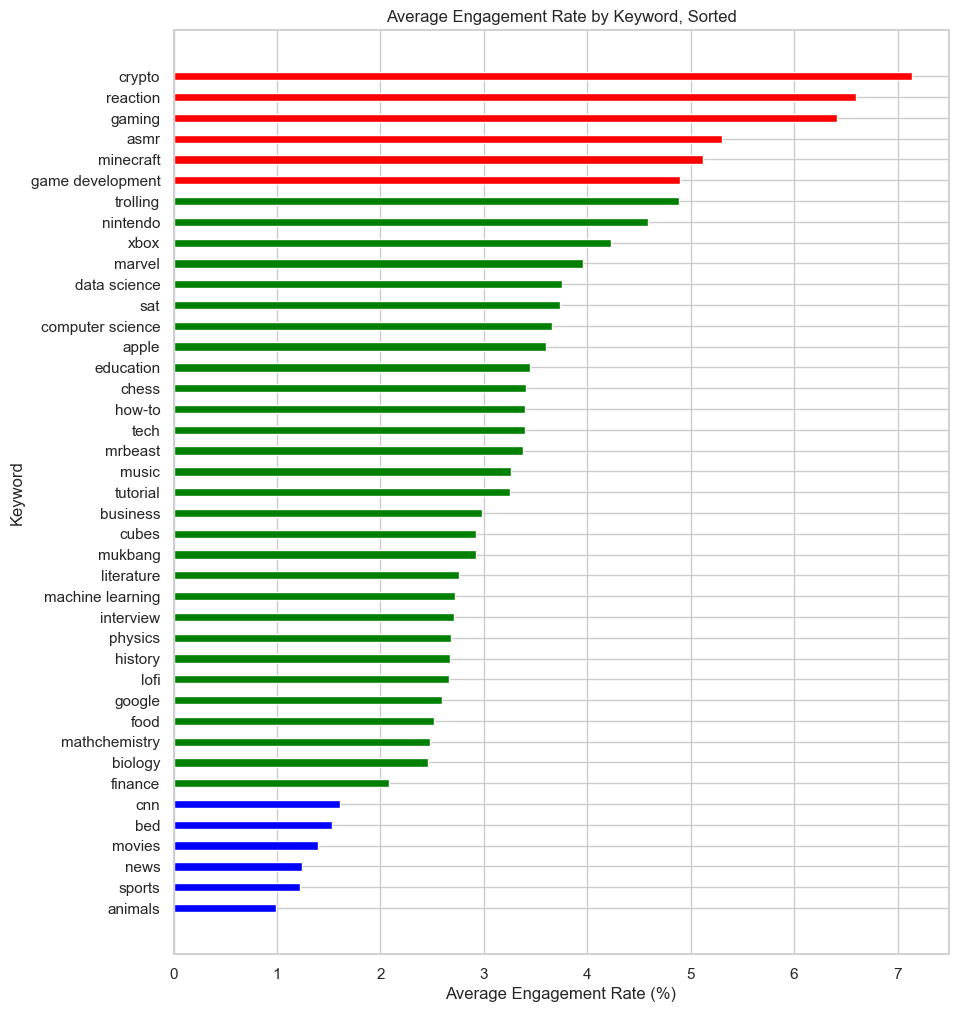

In [251]:
n_bars = len(keyword_engagement_sorted)
colors = ['blue' if i < 6 else 'red' if i >= n_bars - 6 else 'green' for i in range(n_bars)]

plt.figure(figsize=(10, 12))
plt.barh(keyword_engagement_sorted.index, keyword_engagement_sorted.values, color=colors, height=0.4)
plt.ylabel('Keyword')
plt.xlabel('Average Engagement Rate (%)')
plt.title('Average Engagement Rate by Keyword, Sorted')
plt.show()


## Word Cloud of Keywords

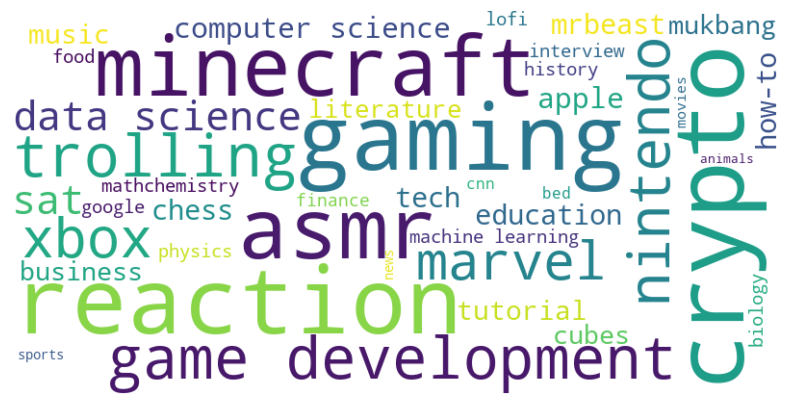

In [240]:
keyword_frequencies = {keyword: value for keyword, value in zip(keyword_engagement.index, keyword_engagement.values)}
wordcloud = WordCloud(width=800, height=400, max_font_size=100, background_color='white').generate_from_frequencies(keyword_frequencies)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Keyword-based Classification

In [173]:
unique_keywords = merged_df['Keyword'].unique()
unique_keywords

array(['tech', 'news', 'gaming', 'sports', 'how-to', 'business',
       'tutorial', 'finance', 'crypto', 'cubes', 'chess', 'apple',
       'google', 'interview', 'history', 'literature', 'bed', 'trolling',
       'asmr', 'music', 'food', 'mukbang', 'reaction', 'lofi', 'animals',
       'education', 'minecraft', 'sat', 'mrbeast', 'cnn', 'mathchemistry',
       'biology', 'physics', 'computer science', 'nintendo', 'xbox',
       'marvel', 'movies', 'data science', 'game development',
       'machine learning'], dtype=object)

- Technology
- Education
- Media & Entertainment
- Food & Beverage
- Gaming
- Sports
- Arts & Entertainment
- Pets & Animals

In [243]:
industry_map = {
    "Technology": [
        "tech", "apple", "google", "computer science", "data science", "machine learning"
    ],
    "Business & Finance": [
        "business", "finance", "crypto", "interview", "news"
    ],
    "Gaming": [
        "gaming", "tutorial", "nintendo", "xbox", "minecraft", "game development"
    ],
    "Media & Entertainment": [
        "movies", "marvel", "mrbeast", "cnn", "mukbang", "reaction"
    ],
    "Sports": [
        "sports", "chess", "cubes"
    ],
    "Education": [
        "how-to", "history", "literature", "education", "math", "chemistry", "biology", "physics", "sat"
    ],
    "Lifestyle & Leisure": [
        "food", "bed", "animals", "trolling", "asmr", "music", "lofi"
    ]
}

In [ ]:
industry_map_data = [(keyword, industry) for industry, keywords in industry_map.items() for keyword in keywords]
industry_map_df = pd.DataFrame(industry_map_data, columns=['Keyword', 'Industry'])
industry_map_df.head()

,Keyword,Industry
0,tech,Technology
1,apple,Technology
2,google,Technology
3,computer science,Technology
4,data science,Technology


In [254]:
merged_df = pd.merge(merged_df, industry_map_df, on='Keyword', how='left')

## Engagement Rate by Industry

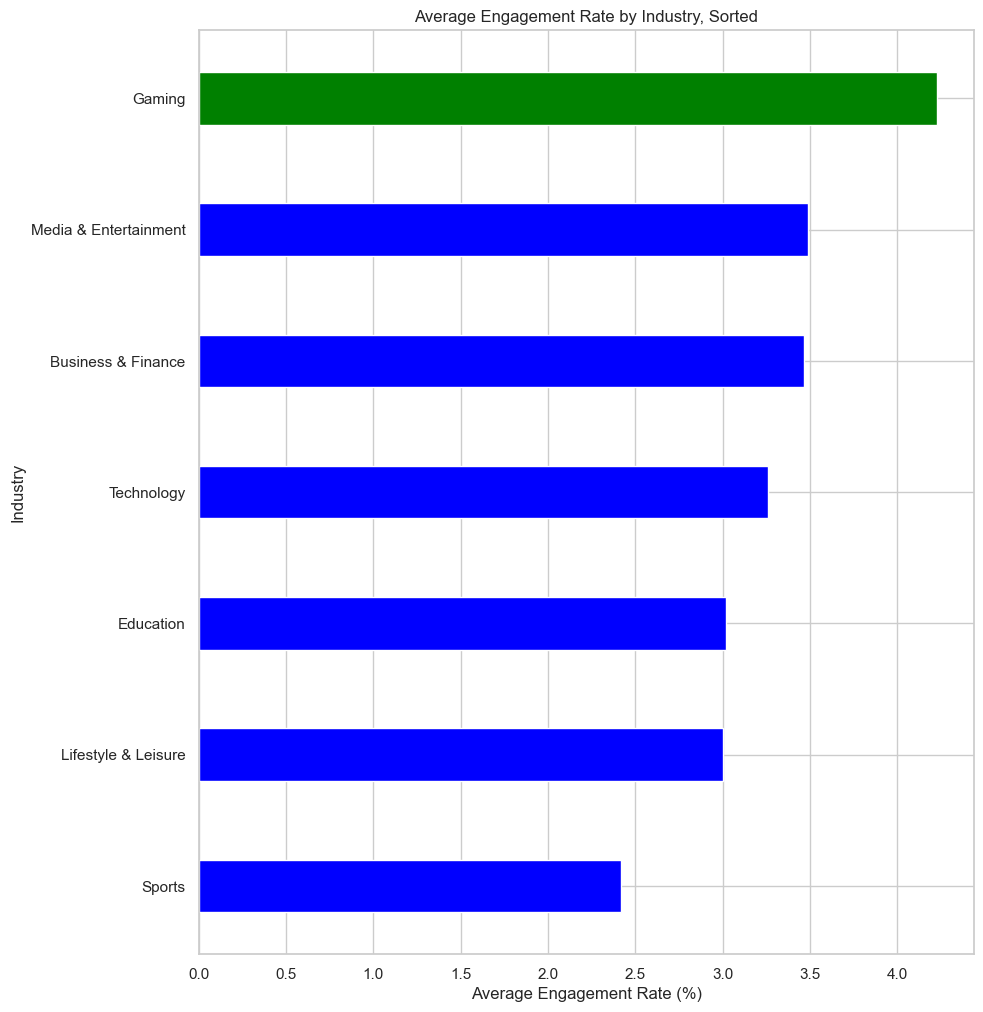

In [179]:

industry_engagement_sorted = merged_df.groupby('Industry')['Engagement Rate'].mean().sort_values(ascending=True)


nn_bars = len(industry_engagement_sorted)

plt.figure(figsize=(10, 12))
plt.barh(industry_engagement_sorted.index, industry_engagement_sorted.values, color=colors, height=0.4)
plt.ylabel('Industry')
plt.xlabel('Average Engagement Rate (%)')
plt.title('Average Engagement Rate by Industry, Sorted')
plt.show()


In [256]:

keyword_popularity = merged_df.groupby(['Industry', 'Keyword']).agg({
    'Likes_x': 'sum',           # Total likes
    'Comments': 'sum',          # Total comments
    'Views': 'sum',             # Total views
    'Engagement Rate': 'mean'   # Mean engagement rate
})


keyword_popularity = keyword_popularity.sort_values(by='Likes_x', ascending=False)
keyword_popularity.head()


Likes_x    Comments         Views  \
Industry              Keyword                                       
Media & Entertainment mrbeast   2643691  18528651.0  1.668902e+10   
                      marvel     747826   4384970.0  2.944442e+09   
Education             how-to     710478   3253467.0  3.562330e+09   
                      biology    642386   1995143.0  1.904990e+09   
Gaming                tutorial   567143   3897276.0  3.123323e+09   

                                Engagement Rate  
Industry              Keyword                    
Media & Entertainment mrbeast          3.345761  
                      marvel           4.030219  
Education             how-to           3.427195  
                      biology          2.471316  
Gaming                tutorial         3.314082

In [257]:
keyword_popularity_df = pd.DataFrame(keyword_popularity, columns=[])
keyword_popularity_df.head()

Empty DataFrame
Columns: []
Index: [(Media & Entertainment, mrbeast), (Media & Entertainment, marvel), (Education, how-to), (Education, biology), (Gaming, tutorial)]

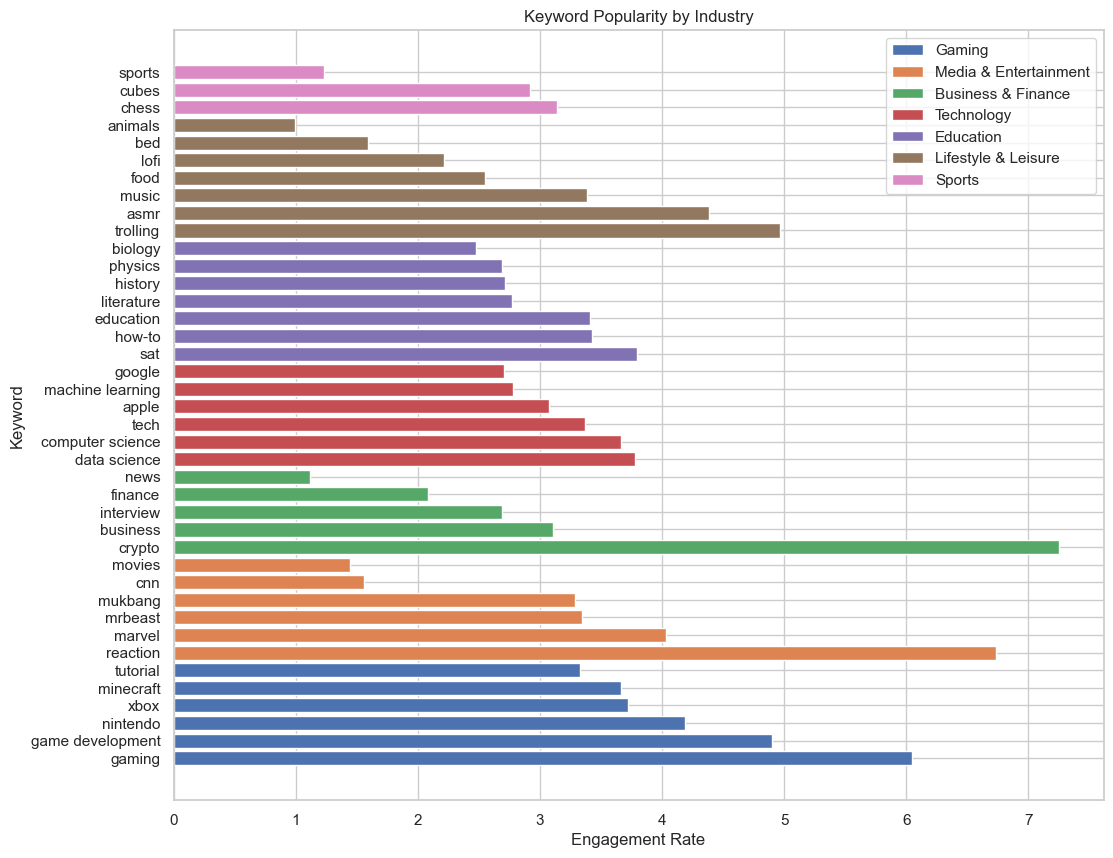

In [182]:
industry_engagement= keyword_popularity.groupby('Industry')['Engagement Rate'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 10))
plt.title('Keyword Popularity by Industry')
plt.xlabel('Engagement Rate')
plt.ylabel('Keyword')


for industry in industry_engagement.index:
    data = keyword_popularity.loc[industry].sort_values(by='Engagement Rate', ascending=False)
    plt.barh(data.index.get_level_values('Keyword'), data['Engagement Rate'], label=industry)

plt.legend()
plt.show()


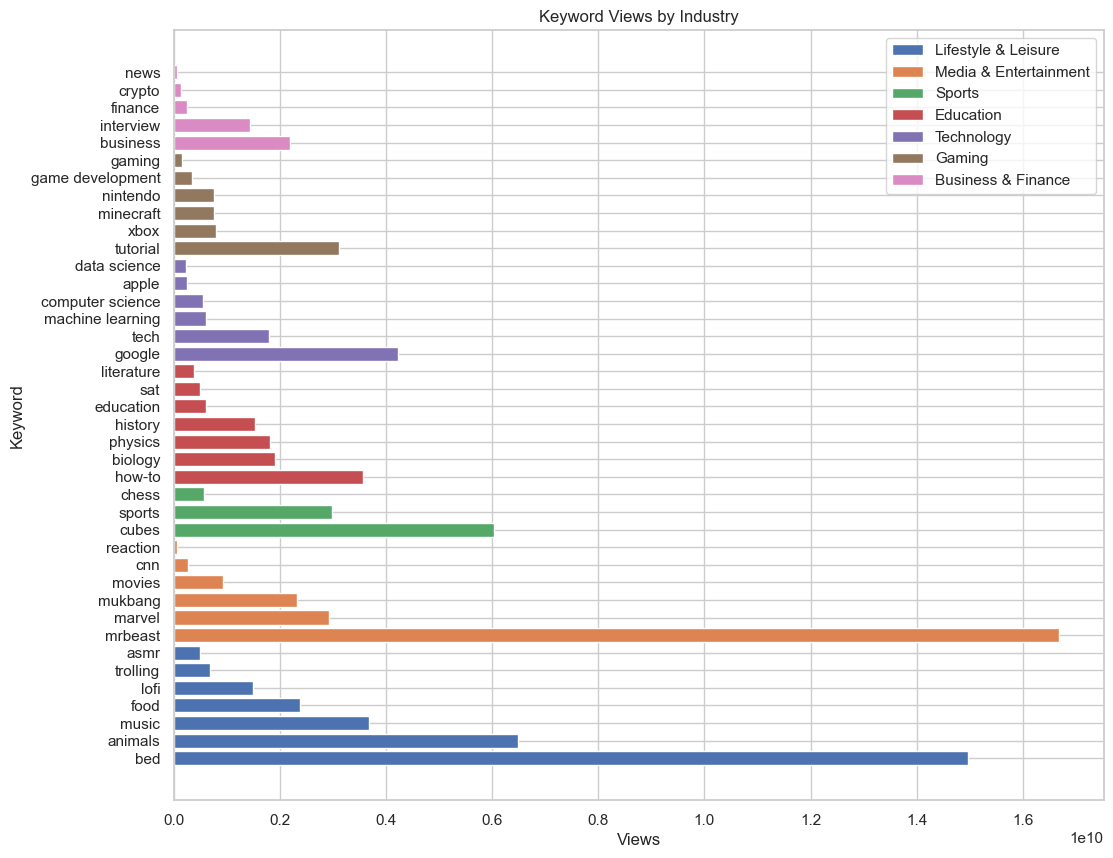

In [183]:
industry_view = keyword_popularity.groupby('Industry')['Views'].mean().sort_values(ascending=False)


plt.figure(figsize=(12, 10))
plt.title('Keyword Views by Industry')
plt.xlabel('Views')
plt.ylabel('Keyword')

for industry in industry_view.index:
    data = keyword_popularity.loc[industry].sort_values(by='Views', ascending=False)
    plt.barh(data.index.get_level_values('Keyword'), data['Views'], label=industry)

plt.legend()

plt.show()


# Sentiment Analysis of Video Comments

Dataset provides the sentiment scale from 0 to 2. <br>

Since Sentiment is only identifying the negativity and positive, it is not as detail as to identify the emotion & opinions. <br>

So we will further investigate the sentiment of the comments after identifying the propotion of positive and negative comments. <br>


## Sentiment Distribution

In [268]:
temp = merged_df.groupby('Sentiment').count()['Comments'].reset_index().sort_values(by='Comments',ascending=False)
sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
temp['Sentiment_Words'] = temp['Sentiment'].map(sentiment_mapping)
temp

,Sentiment,Comments,Sentiment_Words
2,2,10283,Positive
1,1,3236,Neutral
0,0,2250,Negative


<Axes: xlabel='Sentiment', ylabel='count'>

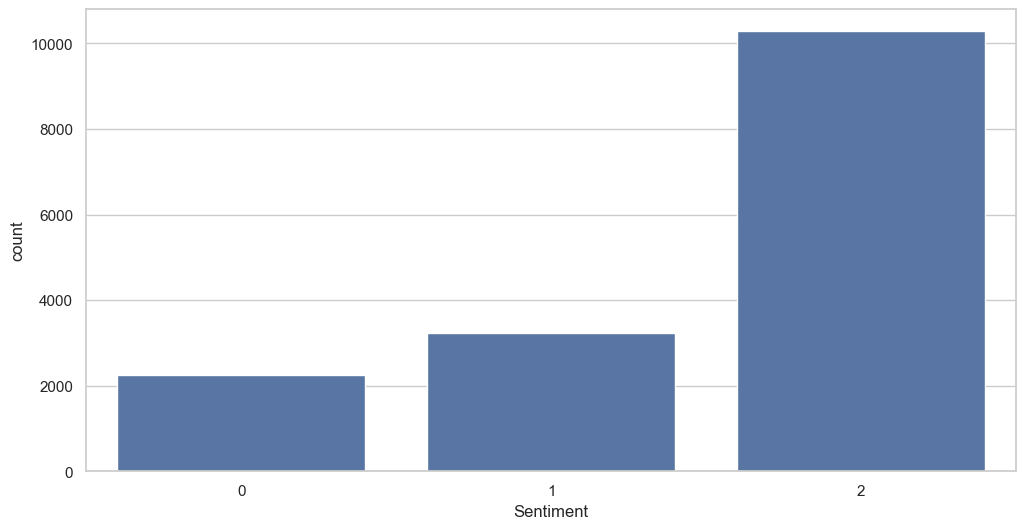

In [271]:
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment',data=merged_df)

This is one of the first element that goes into a sentiment analysis system which is **Opinion**

Opinion has three divisions: positive, neutral, and negative.

In this case
- Positive = 2
- neutral = 1
- nagative = 0


In [187]:
sentiment_percentage = merged_df.Sentiment.value_counts()/len(merged_df)
sentiment_percentage

Sentiment
2    0.651810
1    0.205605
0    0.142585
Name: count, dtype: float64

Overall Positive comments are most common among videos.


Positive comments are 62% <br />
Neutral comments are 25.1% <br />
Negative comments are 12.9%  <br />

Let's find out which types



## Keyword by Average Sentiment


In [272]:
keyword_sentiment = merged_df.groupby(['Industry', 'Keyword']).agg({
    'Sentiment': 'mean' 
})

keyword_sentiment = keyword_sentiment.sort_values(by=['Industry', 'Sentiment'], ascending=[False, False])

keyword_sentiment.head()

Sentiment
Industry   Keyword                    
Technology machine learning   1.756098
           data science       1.711538
           computer science   1.613483
           tech               1.506747
           apple              1.423295

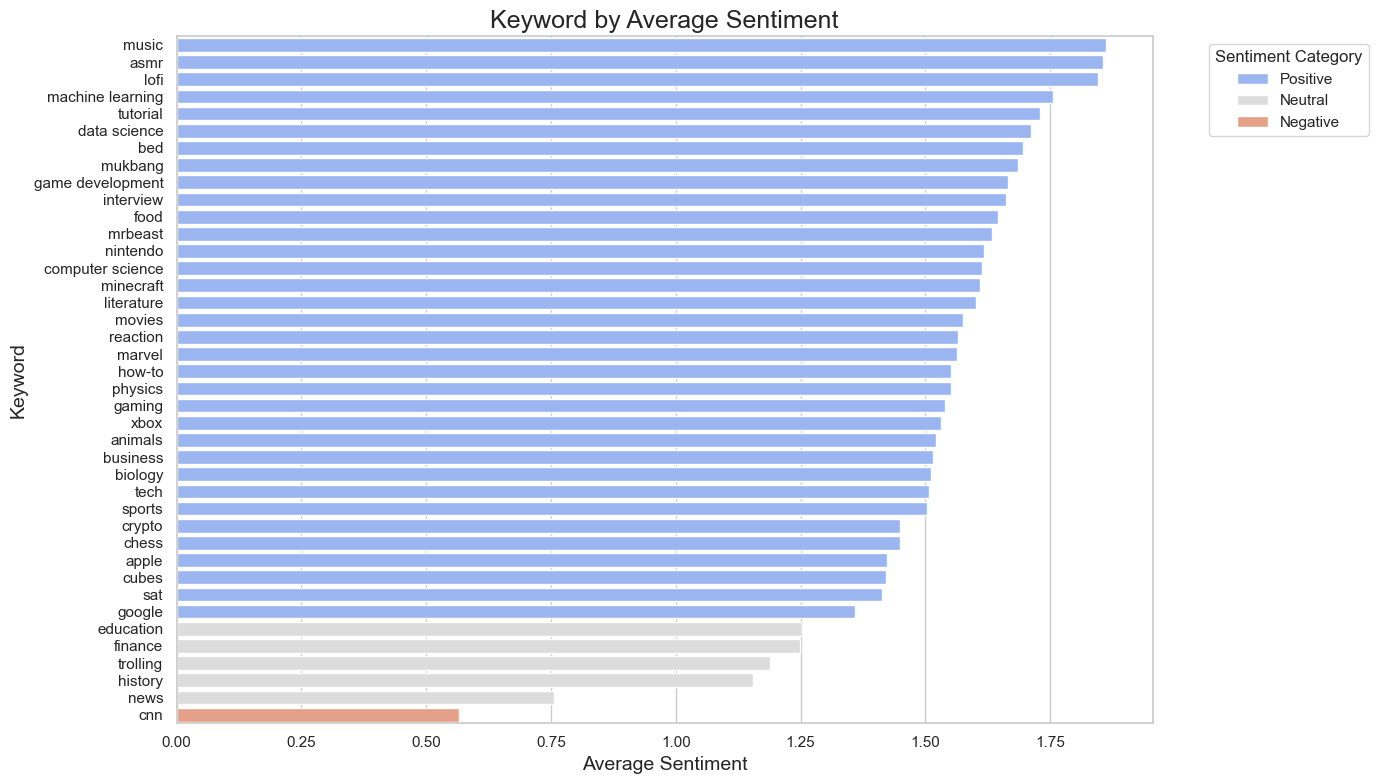

In [275]:
keyword_sentiment = merged_df.groupby(['Industry', 'Keyword']).agg({'Sentiment': 'mean'}).reset_index()
def categorize_sentiment(sentiment):
    if 0 <= sentiment < 0.666:
        return 'Negative'
    elif 0.666 <= sentiment < 1.332:
        return 'Neutral'
    elif 1.332 <= sentiment <= 2:
        return 'Positive'
keyword_sentiment['Sentiment Category'] = keyword_sentiment['Sentiment'].apply(categorize_sentiment)
keyword_sentiment = keyword_sentiment.sort_values(by='Sentiment', ascending=False)
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))
bar_plot = sns.barplot(data=keyword_sentiment, x='Sentiment', y='Keyword', hue='Sentiment Category', palette='coolwarm')
plt.title('Keyword by Average Sentiment', fontsize=18)
plt.xlabel('Average Sentiment', fontsize=14)
plt.ylabel('Keyword', fontsize=14)
plt.legend(title='Sentiment Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Keyword Sentiment by Industry

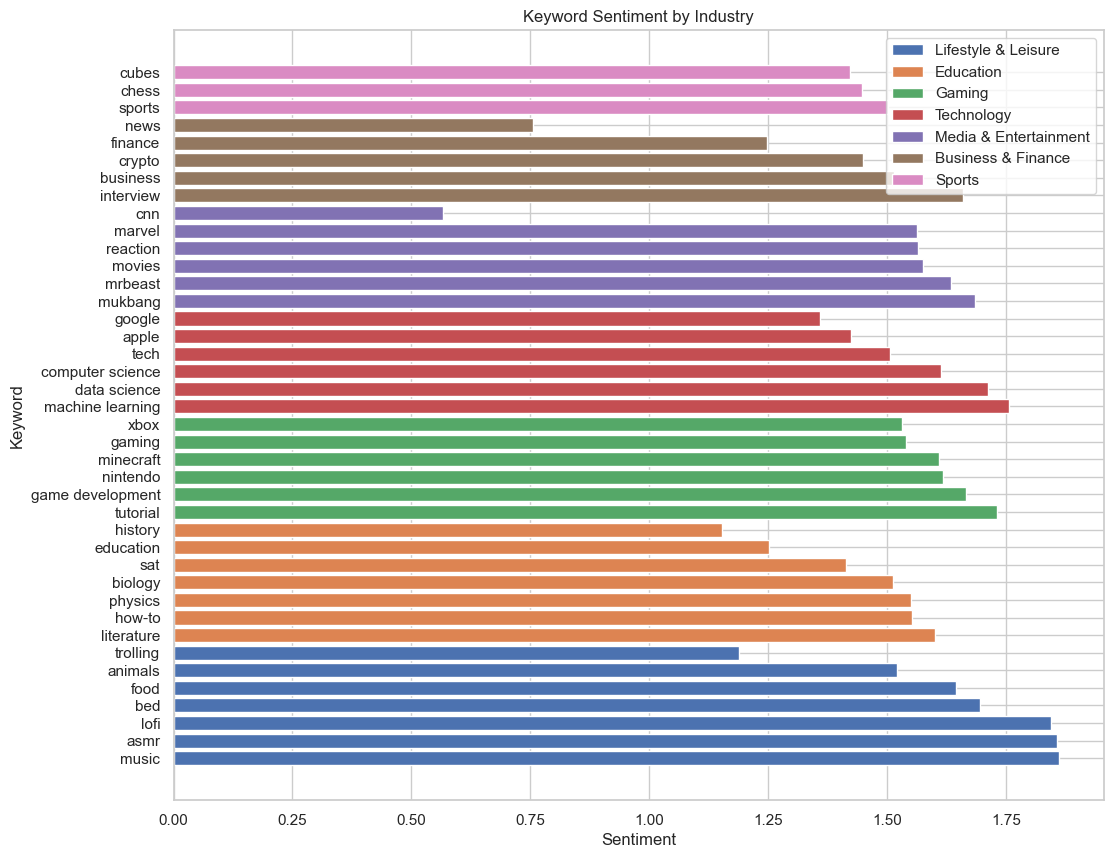

In [277]:
industry_sentiment_sum = keyword_sentiment.groupby('Industry')['Sentiment'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 10))
plt.title('Keyword Sentiment by Industry')
plt.xlabel('Sentiment')
plt.ylabel('Keyword')

for industry in industry_sentiment_sum.index:

    data_sentiment = keyword_sentiment[keyword_sentiment['Industry'] == industry].sort_values(by='Sentiment', ascending=False)


    plt.barh(data_sentiment['Keyword'], data_sentiment['Sentiment'], label=industry)

plt.legend()
plt.show()

## Emotion Analysis

The categorical model of emotion analysis places a person's emotions into six basic categories, like anger, fear, disgust, joy, sadness, and surprise. Specific words are linked to relevant emotion tags and used to detect both related and unrelated emotions([Reference](https://www.delve.ai/blog/emotion-analysis#:~:text=The%20categorical%20model%20of%20emotion,both%20related%20and%20unrelated%20emotions.)).


https://pypi.org/project/NRCLex/



In [281]:
def get_emotion_scores(comment):
    emotions = NRCLex(comment).affect_frequencies
    return emotions
comment_df = merged_df.copy()
comment_df['Emotion Scores'] = comment_df['Comment'].apply(get_emotion_scores)
emotion_columns = ['fear', 'anger', 'anticipation', 'trust', 'surprise', 'sadness', 'disgust', 'joy']
for emotion in emotion_columns:
    comment_df[emotion] = comment_df['Emotion Scores'].apply(lambda x: x.get(emotion.lower(), 0))
comment_df.drop(columns=['Emotion Scores'], inplace=True)
comment_df.to_csv('comment_df.csv', index=False)
comment_df.head()


,Video ID,Comment,Likes_x,Sentiment,Title,Published At,Keyword,Likes_y,Comments,Views,...,Engagement Rate,Industry,fear,anger,anticipation,trust,surprise,sadness,disgust,joy
0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95,1,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,...,2.519689,Technology,0.000000,0.000000,0.000000,0.200000,0.000000,0.200000,0.000000,0.000000
1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19,0,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,...,2.519689,Technology,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161,2,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,...,2.519689,Technology,0.000000,0.000000,0.125000,0.375000,0.000000,0.000000,0.000000,0.250000
3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8,0,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,...,2.519689,Technology,0.090909,0.136364,0.136364,0.090909,0.090909,0.090909,0.045455,0.045455
4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34,2,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,...,2.519689,Technology,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000


## Emotion Distribution

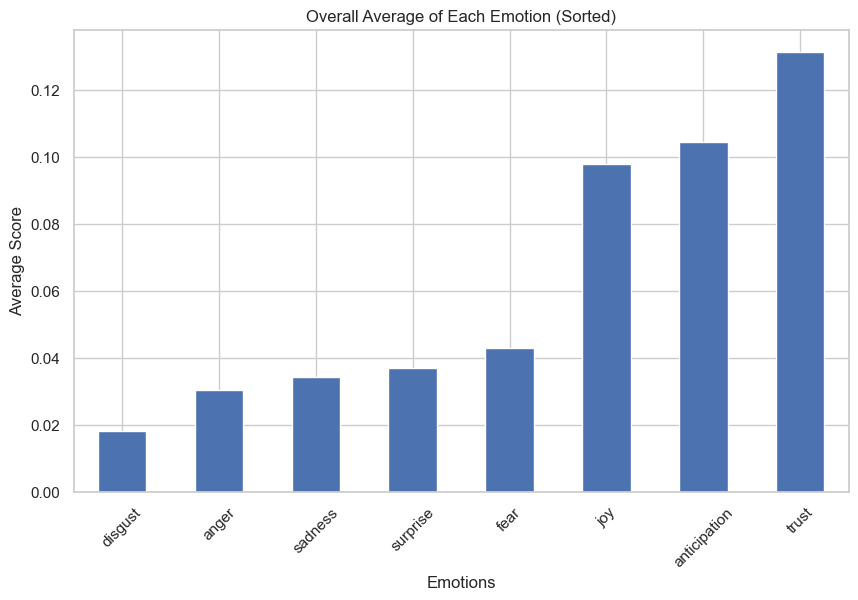

In [285]:
average_emotions = comment_df[emotion_columns].mean().sort_values()

plt.figure(figsize=(10, 6))
average_emotions.plot(kind='bar')
plt.title('Overall Average of Each Emotion (Sorted)')
plt.xlabel('Emotions')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.show()

## Average Emotion Scores by Keyword and Industry

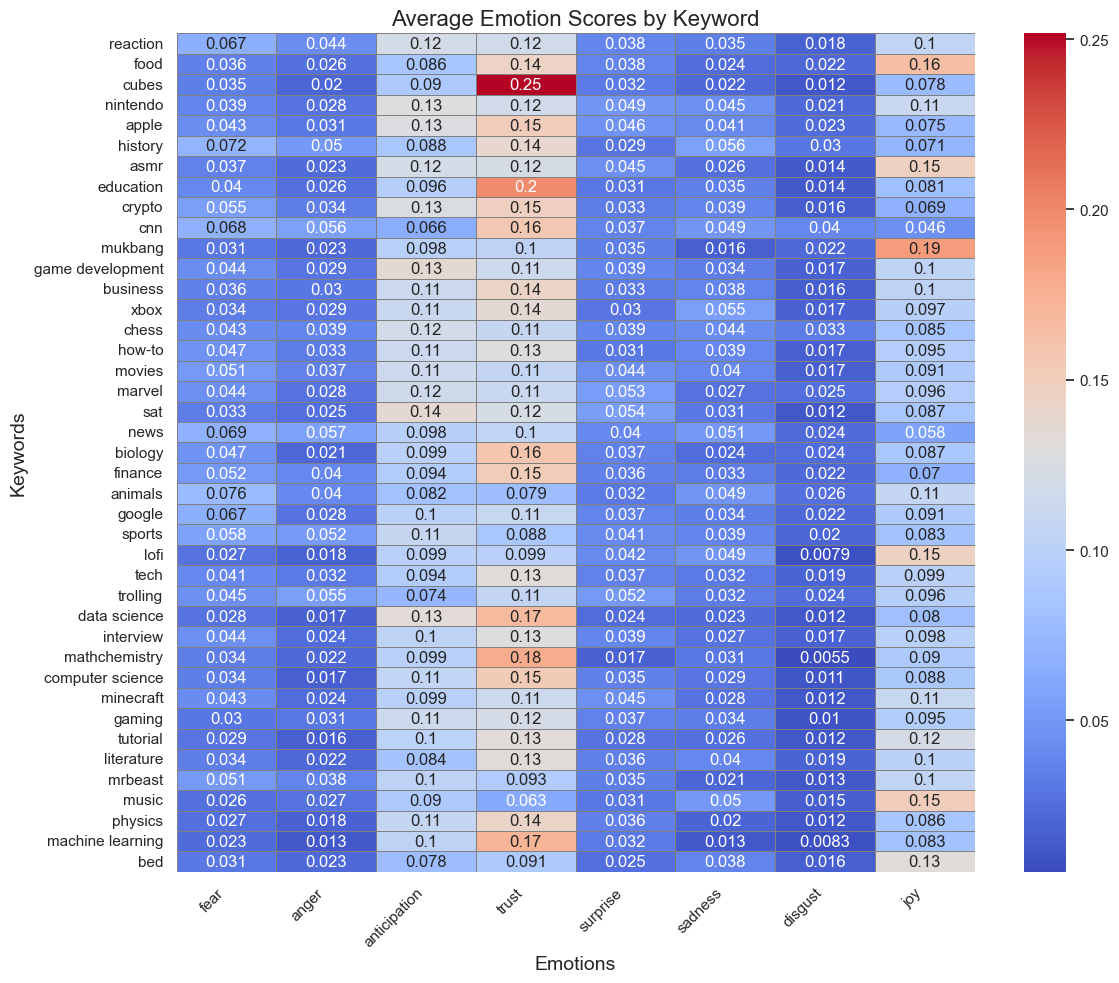

In [282]:
keyword_avg_df = comment_df.groupby('Keyword')[emotion_columns].mean()
keyword_avg_df['Total'] = keyword_avg_df.sum(axis=1)
keyword_avg_df = keyword_avg_df.sort_values(by='Total', ascending=False).drop(columns='Total').reset_index()
plt.figure(figsize=(12, 10))
sns.heatmap(keyword_avg_df.set_index('Keyword'), annot=True, cmap="coolwarm", cbar=True, linewidths=0.5, linecolor='gray')
plt.title("Average Emotion Scores by Keyword", fontsize=16)
plt.xlabel("Emotions", fontsize=14)
plt.ylabel("Keywords", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

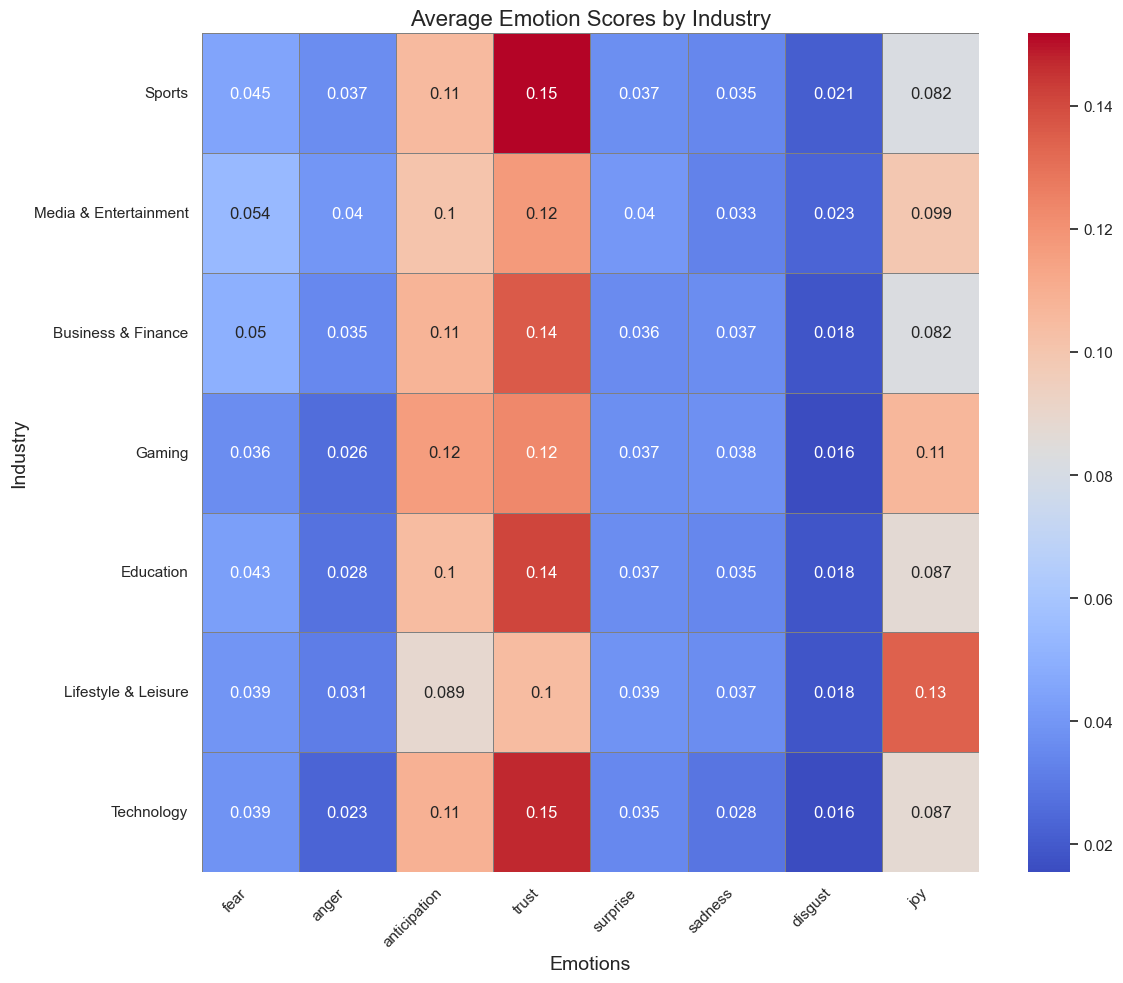

In [283]:
industry_avg_df = comment_df.groupby('Industry')[emotion_columns].mean()

industry_avg_df['Total'] = industry_avg_df.sum(axis=1)

industry_avg_df = industry_avg_df.sort_values(by='Total', ascending=False).drop(columns='Total').reset_index()

plt.figure(figsize=(12, 10))
sns.heatmap(industry_avg_df.set_index('Industry'), annot=True, cmap="coolwarm", cbar=True, linewidths=0.5, linecolor='gray')
plt.title("Average Emotion Scores by Industry", fontsize=16)
plt.xlabel("Emotions", fontsize=14)
plt.ylabel("Industry", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Average Emotion Scores Over Time

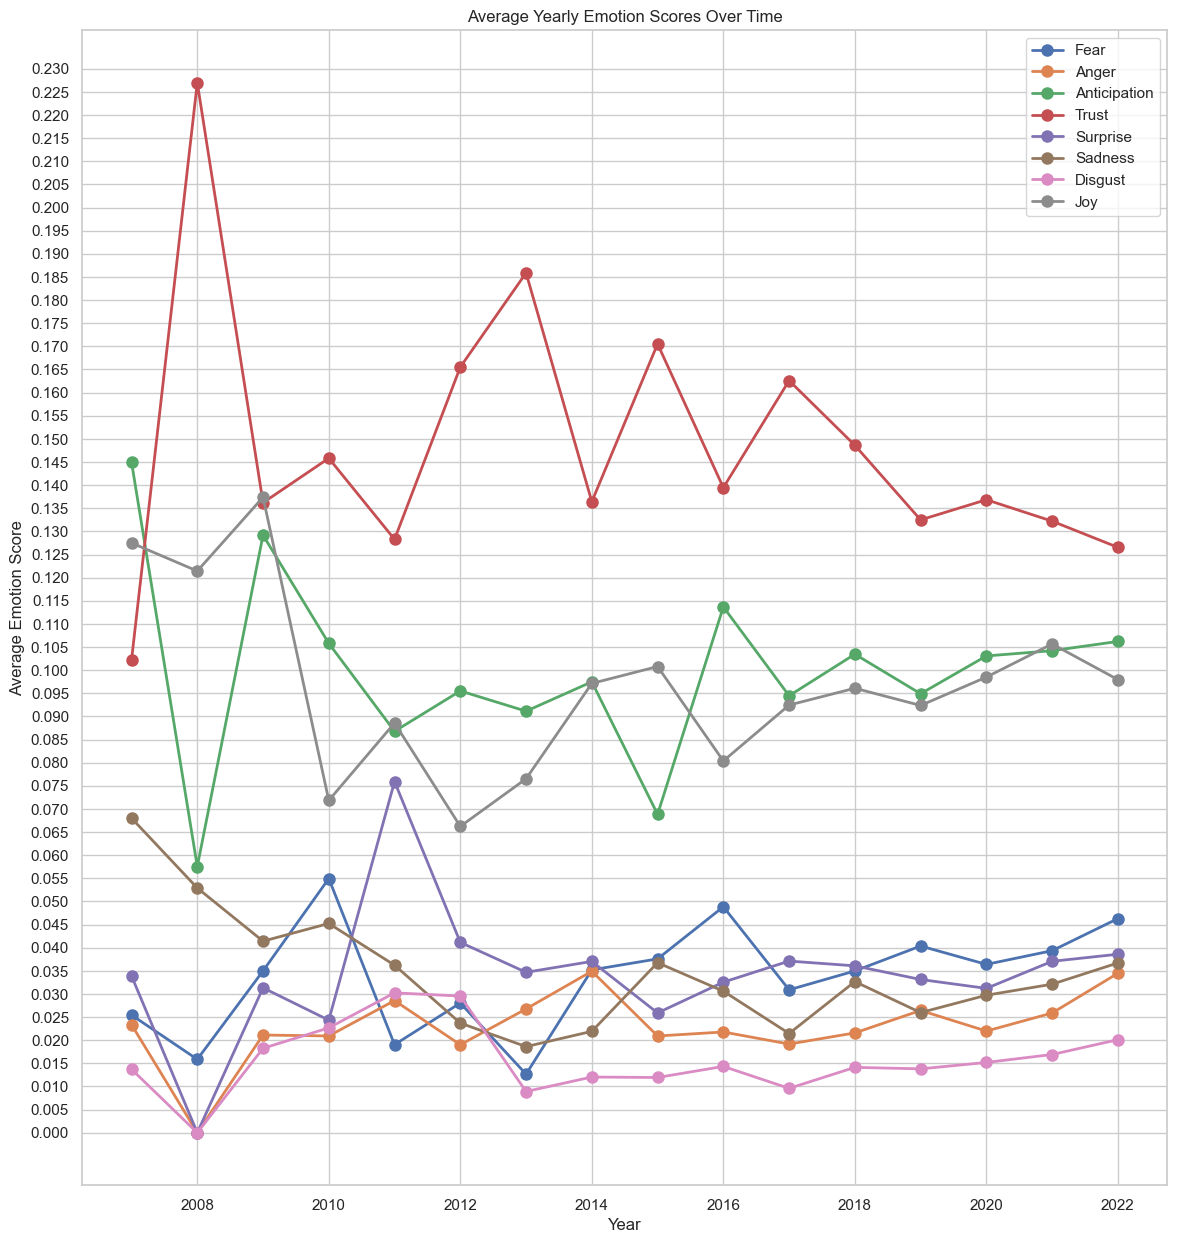

In [284]:
resampled_data = comment_df.resample('Y', on='Published At')[emotion_columns].mean()

plt.figure(figsize=(14, 15))

for emotion in emotion_columns:
    plt.plot(resampled_data.index.year, resampled_data[emotion], marker='o', markersize=8, linestyle='-', linewidth=2, label=emotion.capitalize())

plt.xlabel('Year')
plt.ylabel('Average Emotion Score')
plt.title('Average Yearly Emotion Scores Over Time')
plt.legend()
plt.yticks(np.arange(resampled_data.min().min(), resampled_data.max().max() + 0.005, 0.005))
plt.grid(True)
plt.show()

Specific Trends


In [286]:
trends = {}
for emotion in emotion_columns:
    emotion_data = resampled_data[emotion]
    peaks = emotion_data[(emotion_data.shift(1) < emotion_data) & (emotion_data.shift(-1) < emotion_data)]
    trends[emotion] = {
        'peaks': peaks,
        'max': emotion_data.max(),
        'min': emotion_data.min(),
        'trend': 'decreasing' if emotion_data.iloc[-1] < emotion_data.iloc[0] else 'increasing'
    }
for emotion, data in trends.items():
    print(f"{emotion.capitalize()}:")
    print(f"  Peaks: {data['peaks'].index.year.tolist()} at values {data['peaks'].values}")
    print(f"  Max: {data['max']}")
    print(f"  Min: {data['min']}")
    print(f"  Overall trend: {data['trend']}")


Fear:
  Peaks: [2010, 2012, 2016, 2019] at values [0.05495105 0.02804082 0.04885143 0.04036916]
  Max: 0.05495104879907831
  Min: 0.012666135034556087
  Overall trend: increasing
Anger:
  Peaks: [2009, 2011, 2014, 2016, 2019] at values [0.02112485 0.02857267 0.03491604 0.02178122 0.02644185]
  Max: 0.034916037298581226
  Min: 0.0
  Overall trend: increasing
Anticipation:
  Peaks: [2009, 2012, 2014, 2016, 2018] at values [0.12918904 0.09551243 0.09748067 0.11367295 0.1034535 ]
  Max: 0.14499367952309128
  Min: 0.05753968253968253
  Overall trend: decreasing
Trust:
  Peaks: [2008, 2010, 2013, 2015, 2017, 2020] at values [0.22698413 0.14581555 0.18588029 0.170524   0.16259999 0.13684432]
  Max: 0.22698412698412695
  Min: 0.10219370825253178
  Overall trend: increasing
Surprise:
  Peaks: [2009, 2011, 2014, 2017] at values [0.03132879 0.07591662 0.03704152 0.03711222]
  Max: 0.0759166230594802
  Min: 0.0
  Overall trend: increasing
Sadness:
  Peaks: [2010, 2015, 2018] at values [0.04524017 

#### General observation

- Trust is the most dominant emotion throughout the years, consistently having the highest average scores compared to other emotions.
- Anticipation and Joy also show relatively high scores, with Anticipation peaking several times.
- Surprise, Sadness, Fear, Anger, and Disgust have lower average scores compared to Trust, Anticipation, and Joy.


#### Specific Trends:
- Trust:
    - Peaks around 2007 and 2013.
    - Shows a general decline from 2014 to 2022.
- Anticipation:
    - Highly variable with notable peaks in 2007, 2011, and 2014.
    - Slightly more stable but still fluctuating in the later years.
- Joy:
    - Peaks around 2007 and 2011, followed by smaller peaks in subsequent years.
    - Somewhat stable with moderate fluctuations.
- Sadness, Fear, Anger, and Disgust:
    - All four emotions show lower and more consistent scores over time.
    - Notable peaks for Fear and Sadness around 2010 and 2011.
    - Disgust and Anger have occasional minor peaks but remain relatively low.

#### Yearly Patterns

- Early Years (2006-2010):
    - High variability in emotions, with multiple peaks, especially for Trust, Anticipation, and Fear.
- Middle Years (2011-2015):
    - Trust and Anticipation show notable peaks.
    - Joy remains relatively high but stable.
    - Lower emotions maintain consistency.
- Recent Years (2016-2022):
    - A slight downward trend in Trust.
    - Anticipation and Joy show less variability.
    - Fear, Sadness, Anger, and Disgust remain consistently low.

# 3. Development of a Video Ranking Model


-------

In [199]:
from sklearn.model_selection import train_test_split

In [200]:
rankingdata =pd.DataFrame(comment_df)

In [222]:
# Features and target variable
features = ['Views', 'Likes_y', 'Comments', 'Sentiment']
target = 'Engagement Rate'

# Split the data into training and testing sets
train_df, test_df = train_test_split(rankingdata, test_size=0.3, random_state=42)

# Separate features and target
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (11041, 4)
Testing Data Shape: (4732, 4)


In [223]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define a dictionary to store models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Define evaluation metrics
evaluation_metrics = {
    "Mean Absolute Error": mean_absolute_error,
    "Mean Squared Error": mean_squared_error
}

# Iterate over models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    print(f"Evaluating {name}:")
    for metric_name, metric_func in evaluation_metrics.items():
        metric_value = metric_func(y_test, predictions)
        print(f"{metric_name}: {metric_value:.4f}")
    print("="*30)

Training Linear Regression...
Evaluating Linear Regression:
Mean Absolute Error: 1.6403
Mean Squared Error: 4.9737
Training Decision Tree...
Evaluating Decision Tree:
Mean Absolute Error: 0.0004
Mean Squared Error: 0.0001
Training Random Forest...
Evaluating Random Forest:
Mean Absolute Error: 0.0046
Mean Squared Error: 0.0019
Training Gradient Boosting...
Evaluating Gradient Boosting:
Mean Absolute Error: 0.3556
Mean Squared Error: 0.2852


In [224]:
# Make predictions on the testing data
predictions = model.predict(X_test)

# Evaluate the model using the chosen evaluation metric
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.2851998517305847


-------

In [226]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Initialize the model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.2851998517305847


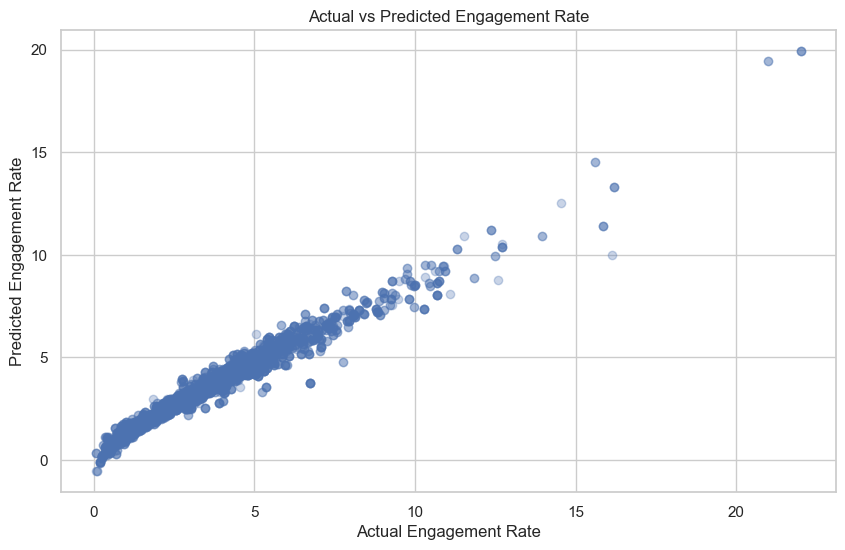

In [227]:
# Scatter plot of actual vs predicted engagement rates
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Engagement Rate')
plt.ylabel('Predicted Engagement Rate')
plt.title('Actual vs Predicted Engagement Rate')
plt.show()

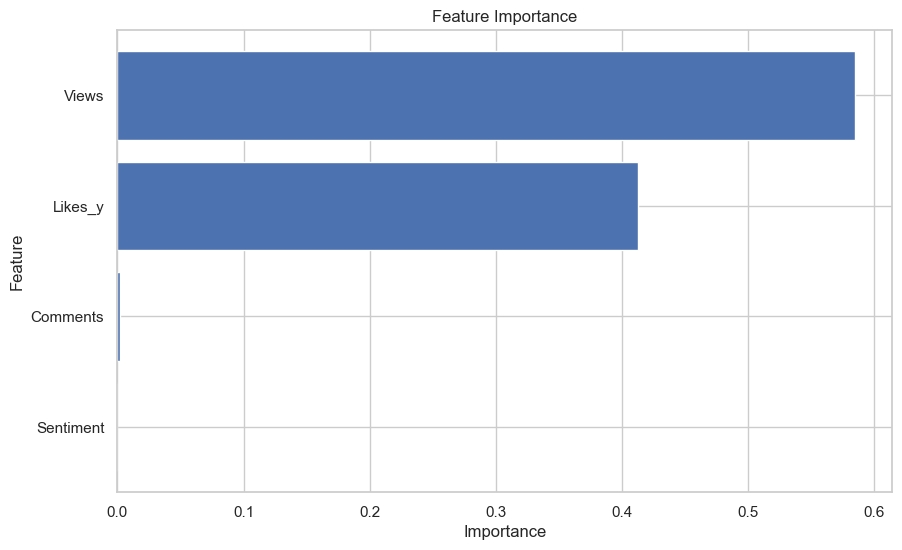

In [228]:
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [230]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initialize the model
grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

# Train the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the final model with best parameters
final_model = GradientBoostingRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Predict on the test set
final_pred = final_model.predict(X_test)

# Evaluate the final model
final_mse = mean_squared_error(y_test, final_pred)
print("Final Mean Squared Error:", final_mse)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Best Score: -0.003947727278653546
Final Mean Squared Error: 0.0007558718493414924


-------

# 4. Strategic Recommendation for E-Learning Collaboration

In [287]:
data_ai_keywords = ["machine learning", "data science", "computer science"]
filtered_df = comment_df[comment_df['Keyword'].isin(data_ai_keywords)]
def sentiment_score(sentiment):
  if sentiment == "positive":
    return 1
  elif sentiment == "negative":
    return -1
  else:
    return 0
filtered_df["sentiment_score"] = filtered_df["Sentiment"].apply(sentiment_score)
filtered_df["engagement_score"] = (filtered_df["sentiment_score"] + filtered_df["comments_count"]) / 2
beginner_keywords = ["education", "tutorial", "basics"]
advanced_keywords = ["advanced", "deep learning", "research"]
weight = 0.8
filtered_df["final_score"] = (weight * filtered_df["engagement_score"]) + (1 - weight)
top_videos = filtered_df.sort_values(by="final_score", ascending=False).head(3)
top_videos_list = top_videos[["Video ID", "Title"]].to_dict('records')
for video in top_videos_list:
  print(f"\t- Video ID: {video['Video ID']}, Title: {video['Title']}")
top_video_ids = top_videos["Video ID"].to_list()
print("Top 3 video IDs for promotion:", top_video_ids)

	- Video ID: Tzl0ELY_TiM, Title: What is Computer Science?
	- Video ID: innk6tpRCW0, Title: Statistics for Data Science Full Course | Probability and Statistics for Engineers | Great Learning
	- Video ID: k2P_pHQDlp0, Title: AI VS ML VS DL VS Data Science
Top 3 video IDs for promotion: ['Tzl0ELY_TiM', 'innk6tpRCW0', 'k2P_pHQDlp0']


## 💪 Competition challenge

Create a report that covers the following:

1. **Exploratory Data Analysis of YouTube Trends:**
   - Conduct an initial analysis of YouTube video trends across different industries. This analysis should explore basic engagement metrics such as views, likes, and comments and identify which types of content are most popular in each industry.

2. **Sentiment Analysis of Video Comments:**
   - Perform a sentiment analysis on video comments to measure viewer perceptions. This task involves basic processing of text data and visualizing sentiment trends across various video categories.

3. **Development of a Video Ranking Model:**
   - Create a simple model that uses sentiment analysis results and traditional engagement metrics to rank videos. This model should help identify potentially valuable videos for specific industry sectors.

4. **Strategic Recommendation for E-Learning Collaboration:**
   - Use your model’s findings to identify YouTube videos that would be particularly effective for an **E-Learning platform focused on Data and AI skills**. Include recommendations for **three specific videos**, briefly explaining why each is ideal for promoting your E-Learning platform.

## 🧑‍⚖️ Judging criteria

| CATEGORY | WEIGHTING | DETAILS                                                              |
|:---------|:----------|:---------------------------------------------------------------------|
| **Recommendations** | 35%       | <ul><li>Clarity of recommendations - how clear and well presented the recommendation is.</li><li>Quality of recommendations - are appropriate analytical techniques used & are the conclusions valid?</li><li>Number of relevant insights found for the target audience.</li></ul>       |
| **Storytelling**  | 35%       | <ul><li>How well the data and insights are connected to the recommendation.</li><li>How the narrative and whole report connects together.</li><li>Balancing making the report in-depth enough but also concise.</li></ul> |
| **Visualizations** | 20% | <ul><li>Appropriateness of visualization used.</li><li>Clarity of insight from visualization.</li></ul> |
| **Votes** | 10% | <ul><li>Up voting - most upvoted entries get the most points.</li></ul> |

## ✅ Checklist before publishing into the competition
- Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
- **Remove redundant cells** like the judging criteria, so the workbook is focused on your story.
- Make sure the workbook reads well and explains how you found your insights.
- Try to include an **executive summary** of your recommendations at the beginning.
- Check that all the cells run without error

## ⌛️ Time is ticking. Good luck!